In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ["OMP_NUM_THREADS"] = "1"

from scipy.io.arff import loadarff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline

In [289]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, method='std', threshold=3):
        self.method = method
        self.threshold = threshold

    def fit(self, X, y=None):
        if self.method == 'std':
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
        elif self.method == 'median':
            self.q1_ = np.percentile(X, 25, axis=0)
            self.q3_ = np.percentile(X, 75, axis=0)
            self.iqr_ = self.q3_ - self.q1_
        return self

    def transform(self, X, y=None):
        if self.method == 'std':
            lower_bound = self.mean_ - self.threshold * self.std_
            upper_bound = self.mean_ + self.threshold * self.std_
        elif self.method == 'median':
            lower_bound = self.q1_ - 1.5 * self.iqr_
            upper_bound = self.q3_ + 1.5 * self.iqr_
        return X.clip(lower_bound, upper_bound, axis = 1)
    
def purity_score(y_true, y_pred):
    contingency = contingency_matrix(y_true, y_pred)
    return np.sum(np.max(contingency, axis=0)) / np.sum(contingency)
    

# Load and transform datasets

In [290]:
iris = load_iris()
iris_X, iris_y = pd.DataFrame(iris.data, columns = iris.feature_names), iris.target


In [291]:
data = []

with open('data/seeds_dataset.txt', 'r') as file:
    for line in file:
        values = line.strip().split('\t')
        while '' in values:
            values.remove('')
        values = [float(value) for value in values]
        data.append(values)

seeds= pd.DataFrame(data, columns=['Area', 'Parameter', 'Compactness', 'Length', 'Width', 'Assymetry_coef', 'Groove_length', 'Class'])
seeds_X, seeds_y = seeds.iloc[:, :-1], seeds.iloc[:, -1]


In [292]:
glass_id = fetch_ucirepo(id=42)
glass = glass_id.data
glass_df = pd.DataFrame(glass['original'])
glass_df.drop(columns="Id_number", inplace=True)
glass_df.rename(columns= {'Type_of_glass':'Class'}, inplace = True)
glass_X, glass_y = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]

In [293]:
year = 1
pcb = pd.DataFrame(loadarff(fr"C:\Users\krzys\Sztuczna Inteligencja\Semestr 1\ML\data\polish+companies+bankruptcy+data/{year}year.arff")[0])
pcb_pipe = Pipeline([('Outliers Remover', OutlierRemover()),('Simple Imputer', SimpleImputer(strategy='mean')), ('Standard Scaler', StandardScaler())])
pcb['class'] = pcb['class'].apply(lambda x: int(x))
pcb_X, pcb_y = pcb.iloc[:, :-1], pcb.iloc[:, -1]
pcb_cols = pcb_X.columns
pcb_X = pd.DataFrame(pcb_pipe.fit_transform(pcb_X), columns = pcb_cols)

# Sanity check

Silhouette score: 0.5511916046195919
Davies-Bouldin index: 0.6660385791628468
Rand Index: 0.7163421126838476
Purity: 0.8866666666666667


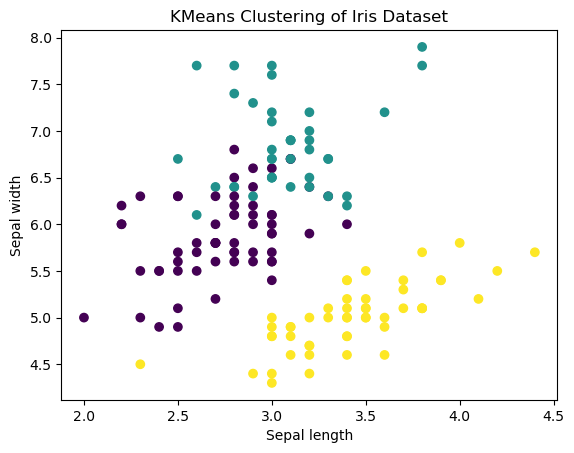

In [294]:
iris_KM = KMeans(n_clusters=3)
iris_KM.fit(iris_X, iris_y)

labels = iris_KM.predict(iris_X)

silhouette = silhouette_score(iris_X, labels)
print("Silhouette score:", silhouette)


davies_bouldin = davies_bouldin_score(iris_X, labels)
print("Davies-Bouldin index:", davies_bouldin)

rand_index = adjusted_rand_score(iris_y, labels)
print("Rand Index:", rand_index)

purity = purity_score(iris_y, labels)
print("Purity:", purity)

# Zwizualizowanie klastrów w przestrzeni dwuwymiarowej
plt.scatter(iris_X.iloc[:, 1], iris_X.iloc[:, 0], c=labels, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('KMeans Clustering of Iris Dataset')
plt.show()

# KMEANS SEEDS GLASS

In [295]:
n_clusters_list = [2, 3, 4, 5]
n_init_list = [5, 10, 15]
max_iter_list = [100, 200, 300]
params = {'n_clusters': n_clusters_list, "n_init": n_init_list, "max_iter":max_iter_list}
def make_clusters(X,y, params = params, model = KMeans):
    results = {}
    plot_data = {}
    for key, param_list in params.items():
        res_data = pd.DataFrame(columns= [key, "Silhouette score","Davies-Bouldin index", "Rand Index", "Purity"])
        highest_purity = 0
        for i, param in enumerate(param_list):
            cluster = model(**{key:param})
            if model == KMeans:
                cluster.fit(X,y)
                labels = cluster.predict(X)
            else:
                labels = cluster.fit_predict(X)
            res_data.loc[i] = param, silhouette_score(X,labels), davies_bouldin_score(X, labels), adjusted_rand_score(y, labels), purity_score(y, labels)
            if  purity_score(y, labels) > highest_purity:
                highest_purity= purity_score(y, labels)
                plot_data[key] = {'X': X, 'y':labels}
        results[key] = res_data
    return results, plot_data

def make_plot(data, key, model_name = 'KMeans'):
    X, labels = data[key]['X'], data[key]['y']
    plt.scatter(X.iloc[:, 1], X.iloc[:, 0], c=labels, cmap='viridis')
    plt.xlabel(f'{X.columns[1]}')
    plt.ylabel(f'{X.columns[0]}')
    plt.title(f'{model_name} Clustering of {key}')
    plt.show()

- Silhouette score 
    - mierzy, jak dobrze punkty w klastrze są od siebie oddzielone i jak dobrze pasują do swojego klastra. Jest obliczany dla każdego punktu, a następnie średnia dla wszystkich punktów jest brana jako końcowy wynik. Wartości od -1 do 1.
- Davies-Bouldin index 
    - mierzy średnią odległość między klastrami oraz dyspersję wewnątrz klastrów. Mniejsza wartość oznacza lepsze klastrowanie.
- Rand Index 
    - mierzy podobieństwo między dwoma zestawami klastrów, porównując pary punktów. Uwzględnia zarówno pary punktów, które są w tym samym klastrze w obu zestawach, jak i pary, które są w różnych klastrach. Wartości od 0 do 1.
- Purity 
    - mierzy czystość klastrów względem znanych klas. Jest to wskaźnik, jak dobrze punkty w klastrze są przypisane do jednej, dominującej klasy. Wartości od 0 do 1.


## GLASS

,n_clusters,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,2.0,0.532929,0.887367,0.037111,0.383178
1,3.0,0.575046,0.912392,0.222278,0.485981
2,4.0,0.426466,1.020259,0.237512,0.546729
3,5.0,0.555569,0.862418,0.251546,0.528037


,n_init,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,5.0,0.265740,1.017408,0.244848,0.658879
1,10.0,0.461899,0.856696,0.278283,0.598131
2,15.0,0.457479,0.857972,0.279288,0.602804


,max_iter,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,100.0,0.278624,0.971324,0.208374,0.570093
1,200.0,0.409612,0.927947,0.284361,0.593458
2,300.0,0.420221,1.061567,0.254103,0.593458


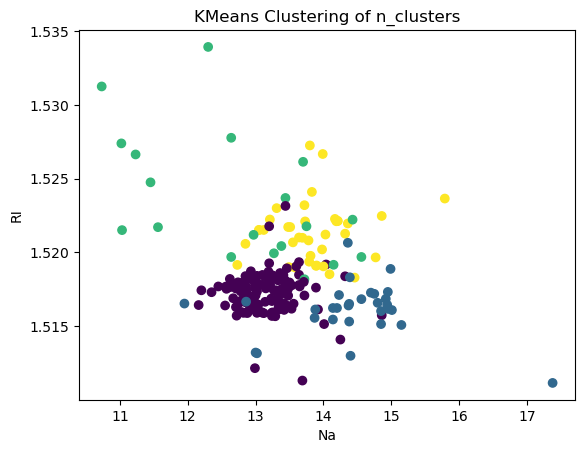

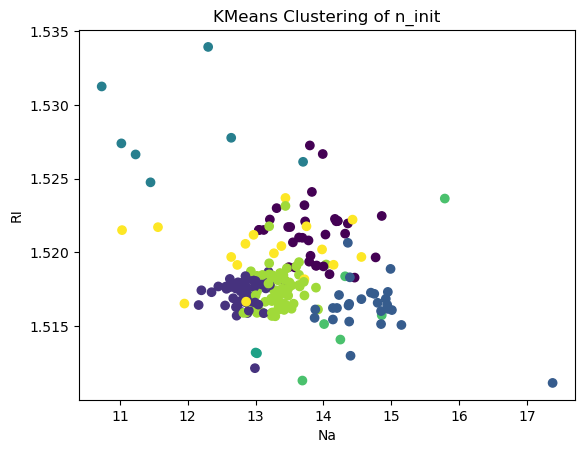

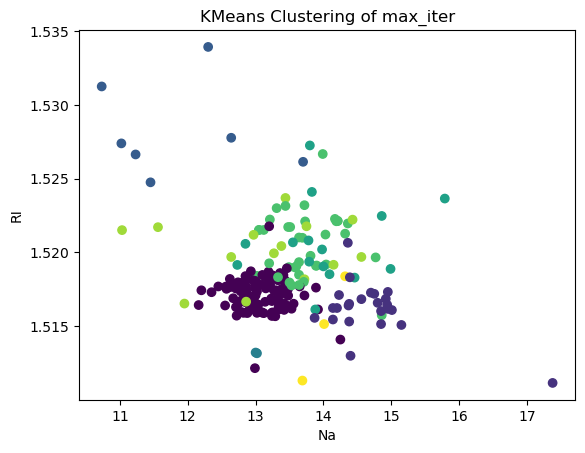

In [296]:
results, plot_data = make_clusters(glass_X, glass_y)
display(results['n_clusters'])
display(results['n_init'])
display(results['max_iter'])
make_plot(plot_data, 'n_clusters')
make_plot(plot_data, 'n_init')
make_plot(plot_data, 'max_iter')

## SEEDS

,n_clusters,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,2.0,0.518287,0.690980,0.468323,0.661905
1,3.0,0.471934,0.753314,0.716620,0.895238
2,4.0,0.412528,0.825478,0.627425,0.890476
3,5.0,0.360345,0.910610,0.540858,0.876190


,n_init,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,5.0,0.360804,0.935916,0.394931,0.904762
1,10.0,0.361925,0.935942,0.401047,0.909524
2,15.0,0.365015,0.925172,0.389321,0.890476


,max_iter,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,100.0,0.335223,0.973605,0.376018,0.895238
1,200.0,0.325496,0.956402,0.363561,0.900000
2,300.0,0.355975,0.962388,0.395084,0.904762


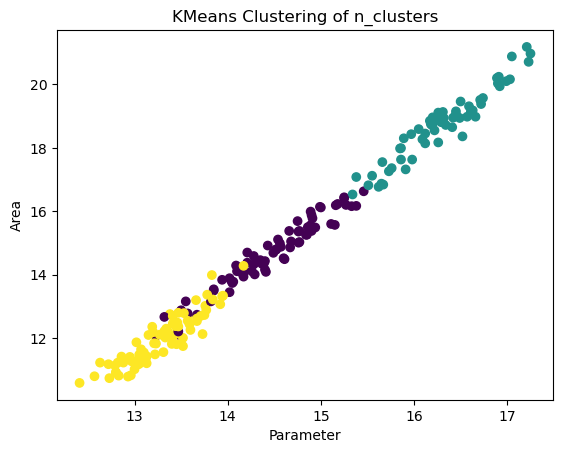

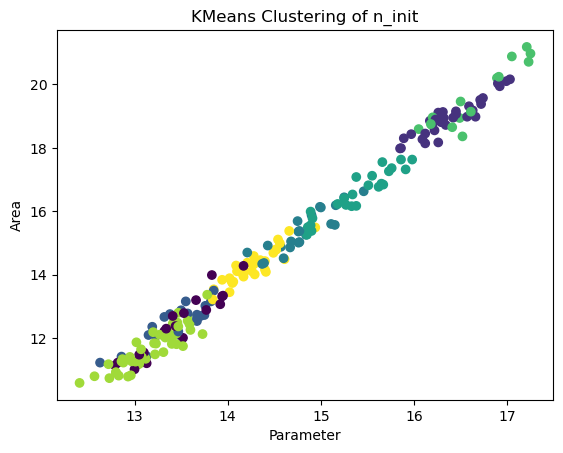

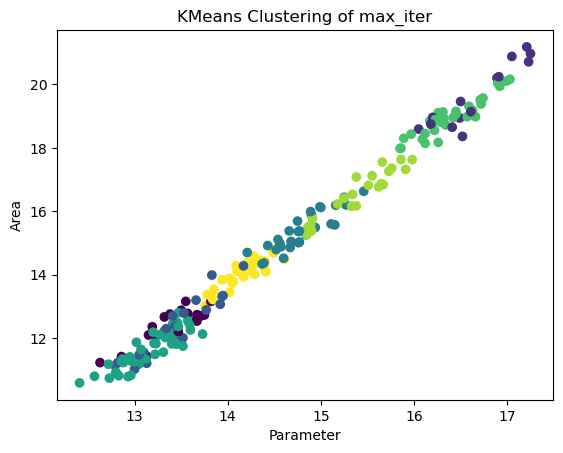

In [297]:
results, plot_data = make_clusters(seeds_X, seeds_y)
display(results['n_clusters'])
display(results['n_init'])
display(results['max_iter'])
make_plot(plot_data, 'n_clusters')
make_plot(plot_data, 'n_init')
make_plot(plot_data, 'max_iter')

# DBSCAN SEEDS GLASS

In [298]:
eps_list = [0.4, 0.7, 1.0, 1.3, 1.5]
min_samples_list = [3, 5, 10, 15, 20]
metric_list = ['euclidean', 'manhattan']
params = {'eps': eps_list, "min_samples": min_samples_list, "metric":metric_list}

## GLASS

,eps,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,0.4,0.012941,1.514577,0.078374,0.425234
1,0.7,0.459371,1.416482,0.242055,0.495327
2,1.0,0.310912,1.941450,0.284459,0.514019
3,1.3,0.510529,2.177462,0.238735,0.504673
4,1.5,0.532633,2.324583,0.244760,0.485981


,min_samples,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,3.0,0.126609,1.688247,0.206140,0.542056
1,5.0,0.252856,1.388571,0.160477,0.490654
2,10.0,0.247579,1.509180,0.055108,0.355140
3,15.0,0.223263,1.530213,0.041131,0.355140
4,20.0,0.209114,1.552593,0.034317,0.355140


,metric,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,euclidean,0.252856,1.388571,0.160477,0.490654
1,manhattan,-0.277811,1.757626,-0.020985,0.429907


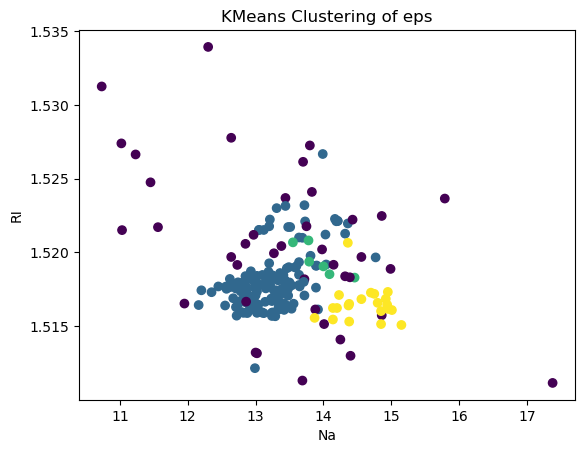

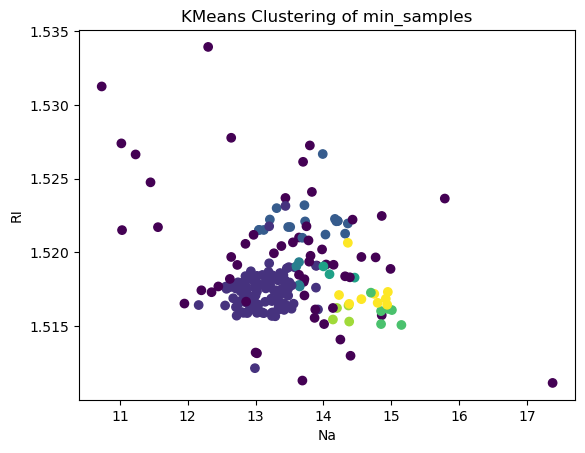

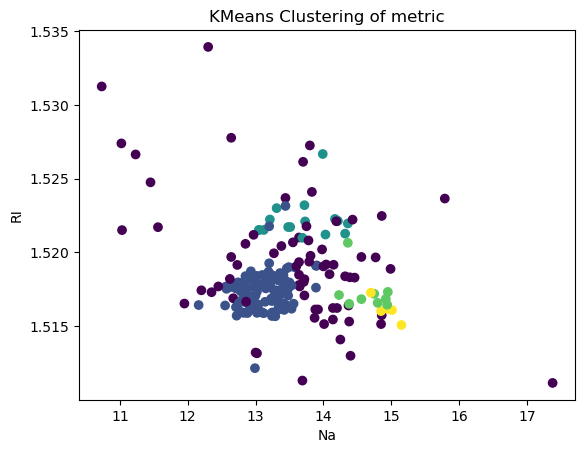

In [299]:
results, plot_data = make_clusters(glass_X, glass_y, params, DBSCAN)
display(results['eps'])
display(results['min_samples'])
display(results['metric'])
make_plot(plot_data, 'eps')
make_plot(plot_data, 'min_samples')
make_plot(plot_data, 'metric')

## SEEDS

,eps,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,0.4,-0.402281,1.391801,0.018082,0.471429
1,0.7,0.216236,2.241126,0.431949,0.809524
2,1.0,0.180785,1.367994,0.003166,0.371429
3,1.3,0.268647,1.552045,0.000003,0.342857
4,1.5,0.216225,0.605776,0.000000,0.338095


,min_samples,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,3.0,-0.115575,1.731373,0.214631,0.747619
1,5.0,-0.286722,1.642882,0.055718,0.547619
2,10.0,0.149779,0.710621,0.008600,0.380952
3,7.0,-0.367343,1.679227,0.016940,0.461905
4,8.0,-0.318432,2.223946,0.012226,0.423810


,metric,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,euclidean,-0.286722,1.642882,0.055718,0.547619
1,chebyshev,0.093049,3.312079,0.226276,0.585714


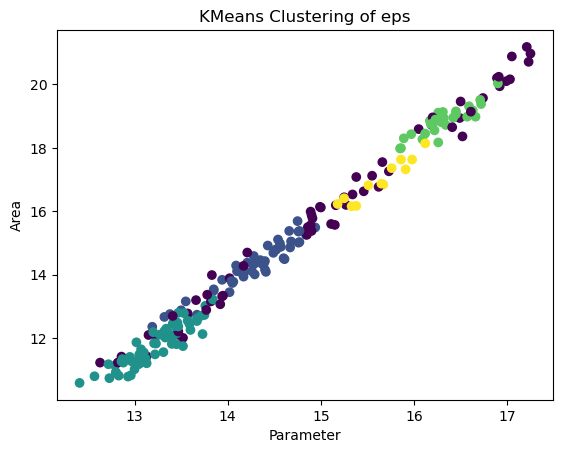

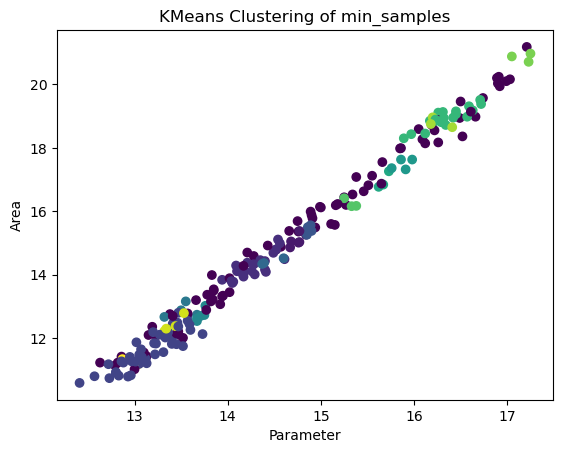

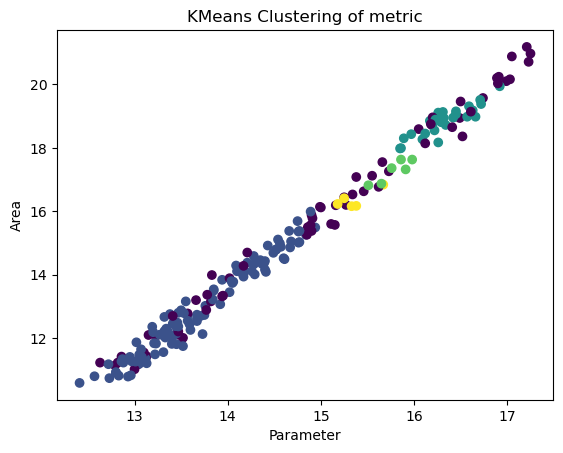

In [300]:
eps_list = [0.4, 0.7, 1.0, 1.3, 1.5]
min_samples_list = [3, 5, 10, 7, 8]
metric_list = ['euclidean', 'chebyshev']
params = {'eps': eps_list, "min_samples": min_samples_list, "metric":metric_list}

results, plot_data = make_clusters(seeds_X, seeds_y, params, DBSCAN)
display(results['eps'])
display(results['min_samples'])
display(results['metric'])
make_plot(plot_data, 'eps')
make_plot(plot_data, 'min_samples')
make_plot(plot_data, 'metric')

# Wnioski

KMeans jest lepszy niz DBSCAN

,n_clusters,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,2.0,0.922151,0.609742,-0.004622,0.961434
1,3.0,0.922578,0.456188,-0.004863,0.961434
2,4.0,0.699140,0.802184,-0.009600,0.961434
3,5.0,0.523663,0.985330,-0.015572,0.961434


,n_init,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,5.0,0.429757,0.935854,-0.023334,0.961434
1,10.0,0.508873,0.870827,-0.018382,0.961577
2,15.0,0.703387,0.839567,-0.008848,0.961434


,max_iter,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,100.0,0.398820,0.965781,-0.022201,0.961577
1,200.0,0.529299,0.860111,-0.015779,0.961434
2,300.0,0.208529,1.361954,-0.019366,0.961434


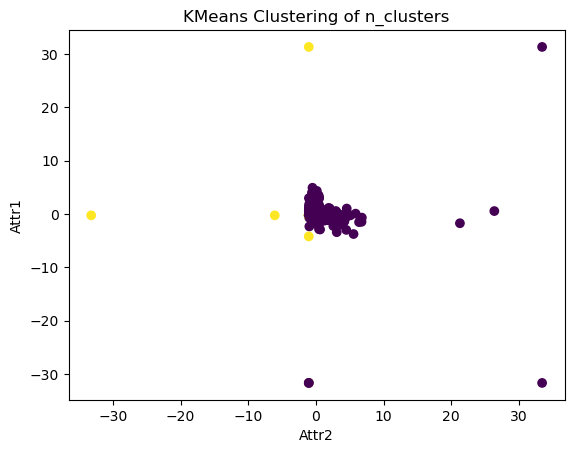

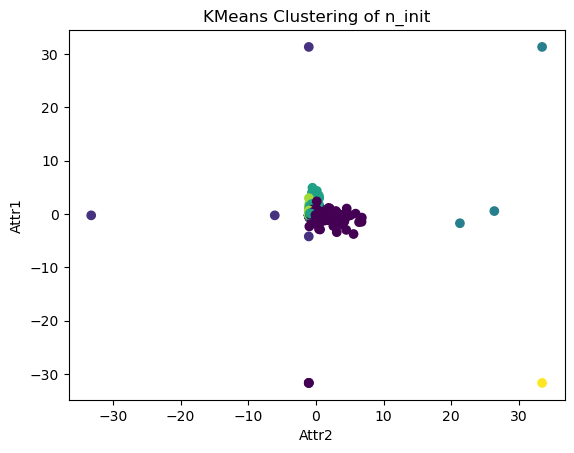

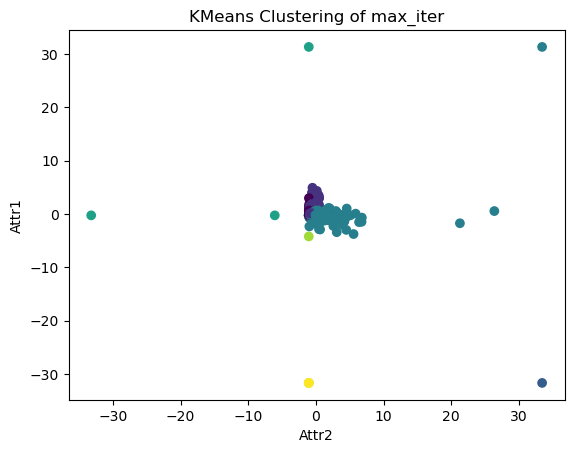

In [301]:
n_clusters_list = [2, 3, 4, 5]
n_init_list = [5, 10, 15]
max_iter_list = [100, 200, 300]
params = {'n_clusters': n_clusters_list, "n_init": n_init_list, "max_iter":max_iter_list}

results, plot_data = make_clusters(pcb_X, pcb_y)
display(results['n_clusters'])
display(results['n_init'])
display(results['max_iter'])
make_plot(plot_data, 'n_clusters')
make_plot(plot_data, 'n_init')
make_plot(plot_data, 'max_iter')

,eps,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,0.4,-0.551466,2.805693,-0.004767,0.961434
1,0.7,-0.161637,3.683176,-0.002547,0.961434
2,1.0,-0.036967,2.382521,0.005069,0.961434
3,1.3,0.084931,3.399343,0.012355,0.961434
4,1.5,0.082993,2.407210,0.014072,0.961434


,min_samples,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,3.0,-0.552336,2.677280,-0.003200,0.961434
1,5.0,-0.524444,3.008801,-0.002652,0.961434
2,10.0,-0.453109,2.922222,0.002069,0.961434
3,7.0,-0.467292,3.188732,-0.000416,0.961434
4,8.0,-0.479967,2.998885,0.000978,0.961434


,metric,Silhouette score,Davies-Bouldin index,Rand Index,Purity
0,euclidean,-0.524444,3.008801,-0.002652,0.961434
1,chebyshev,-0.209930,2.783610,0.009023,0.961434
2,cosine,0.934252,1.385222,-0.000811,0.961434


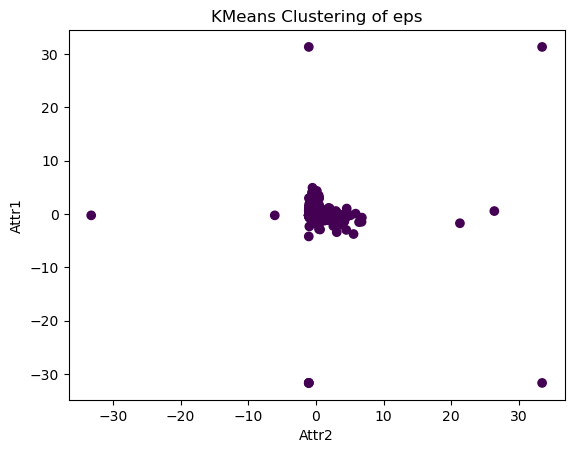

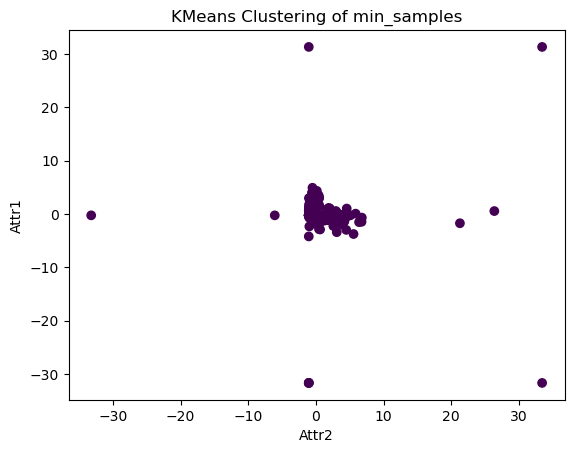

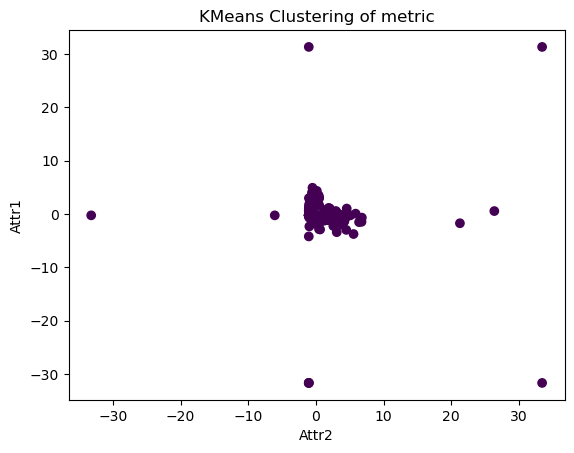

In [302]:
eps_list = [0.4, 0.7, 1.0, 1.3, 1.5]
min_samples_list = [3, 5, 10, 7, 8]
metric_list = ['euclidean', 'chebyshev', 'cosine']
params = {'eps': eps_list, "min_samples": min_samples_list, "metric":metric_list}

results, plot_data = make_clusters(pcb_X, pcb_y, params, DBSCAN)
display(results['eps'])
display(results['min_samples'])
display(results['metric'])
make_plot(plot_data, 'eps')
make_plot(plot_data, 'min_samples')
make_plot(plot_data, 'metric')